# Section 5. Nonlinear regression


Up to this point, we have seen how to train and validate linear models that best fit some data. However, what if our data is more complex and cannot be well approximated by a simple straight line?

In such cases, we have the option (spoiler alert!) of using artificial neural networks. But don't worry! There is a simpler alternative: we can actually fit a linear model to nonlinear data. To do this, we just need to replace our original set of independent variables, $\mathbf{X}$, with a library $\boldsymbol{\phi}(\mathbf{x}) = \begin{bmatrix} \boldsymbol{\phi}_1(\mathbf{x}), \boldsymbol{\phi}_2(\mathbf{x}), \cdots, \boldsymbol{\phi}_l (\mathbf{x}) \end{bmatrix}^{\text{T}}$ of $l$ candidate basis functions, such as polynomials, trigonometric or radial basis functions, or any other user-supplied function. By doing this, the hypothesis becomes:

\begin{equation}
\hat{y} = \boldsymbol{\theta}^{\text{T}} \boldsymbol{\phi} (\mathbf{x}).
\end{equation}

In the following, we will only consider polynomial functions as candidate basis functions, making the regression polynomial in nature.

## End-to-end example

The best way is to move straightforward to an example. This time, we will also take care of preprocessing the data.

Let us consider a data set given by

\begin{equation}
    y = \sin(|x|)+\sin(x^2)+\mathcal{N}(0,\sigma),
    \label{eq:sin}
\end{equation}

where $\mathcal{N}\left(0,\sigma\right)$ is a normally distributed random variable with mean zero and standard deviation $\sigma$.

But let's start by importing the required libraries, as well as the function for scaling the features.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
np.random.seed(42)

colorb=(0.20392156862745098, 0.43137254901960786, 0.7529411764705882)
colorr = (0.9333333333333333, 0.11372549019607843, 0.13725490196078433)

In [2]:
def scaling(x,fit=False,transform=False,inverse_transform=False,norm=True,param=None):
    
    ''' scale variable x
        :param x: variable
        :type x:  umpy array
        :param fit: find scaling parameters
        :type fit:  bool
        :param transform: scale x
        :type transform:  bool
        :param inverse_transform: inverse scale x
        :type inverse_transform:  bool
        :param norm: inverse scale x
        :type norm:  bool
        :param fit: scaling parameters
        :type fit:  list
    
        :return: scaling parameters (if fit=False)
                 :rtype: list 
                 scaled x (if transform=True)
                 :rtype: numpy array 
                 inverse scaled x (if inverse_transform=True)
                 :rtype: numpy array
    '''
    
    if fit==True:
        if norm==True:
            min_ = np.amin(x); max_ = np.amax(x)
            a = 0.5*(max_-min_)
            b = 0.5*(max_+min_)
        else:
            a = np.std(x)
            b = np.mean(x)
        return [a,b]
    elif transform==True:
        return np.divide(x-param[1],param[0])
    elif inverse_transform==True:
        return np.multiply(x,param[0])+param[1]

We continue by generating the data set and plotting

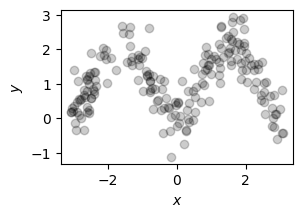

In [3]:
n_snapshots = 200
noise = np.random.normal(0,0.5,(n_snapshots,1)) # generate Gaussian noise
X = np.random.uniform(-np.pi,np.pi,(n_snapshots,1))
y = np.sin(np.abs(X))+np.sin(X)**2+ noise


# plot
fig = plt.figure(figsize=(3., 2.))
plt.plot(X,y,'ko',alpha=0.2)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Now, we proceed by splitting the data set into a training and test set, using Scikit-Learn's train_test_split.

Then, we scale both independent and dependent variables based on the statistics of the training data set.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # split into training and test sets

param_x = scaling(X_train,fit=True) # scaling params for independent variable X
param_y = scaling(y_train,fit=True) # scaling params for dependent variable y

# Scale independent variables (training and test sets)
norm_X_train = scaling(X_train,transform=True,param=param_x) 
norm_X_test = scaling(X_test,transform=True,param=param_x) 

# Scale dependent variables (training and test sets)
norm_y_train = scaling(y_train,transform=True,param=param_y)
norm_y_test = scaling(y_test,transform=True,param=param_y)

At this point, we need to construct the polynomial basis functions using Scikit-Learn's PolynomialFeatures (we will consider up to the sixth degree). Once we have the basis functions, we can proceed with a linear regression.

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_features = PolynomialFeatures(degree=6, include_bias=False)
norm_X_poly = poly_features.fit_transform(norm_X_train) # augment X data set with polynomial features up to degree=degree 
lin_reg = LinearRegression() 
lin_reg.fit(norm_X_poly,norm_y_train) # perform linear regression
lin_reg.intercept_, lin_reg.coef_

(array([-0.35987146]),
 array([[  0.20041976,   7.23777176,  -0.72575099, -16.10685101,
           0.48763306,   8.95138004]]))

Not so difficult! Our model finds the following best-fit equation

\begin{equation*}
    \hat{y} = -0.36 + 0.20 x + 7.24 x^2 -0.73 x^3 -16.11 x^4 + 0.49 x^5 + 8.95 x^6.
\end{equation*}

We can now deploy it to make predictions and compare the latter with the test set

In [6]:
# Make new predictions
x = np.expand_dims(np.linspace(-np.pi,np.pi,200),1)
norm_x = scaling(x,transform=True,param=param_x)
norm_x_poly = poly_features.fit_transform(norm_x)
norm_y_predicted = lin_reg.predict(norm_x_poly)

We can now compare the predictions with the test data set

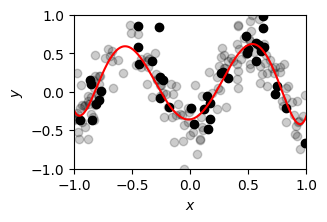

In [7]:
fig = plt.figure(figsize=(3., 2.))
plt.plot(norm_X_train,norm_y_train,'ko',alpha=0.2)
plt.plot(norm_X_test,norm_y_test,'ko')
plt.plot(norm_x,norm_y_predicted,'r-')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-1,1)
plt.xlim(-1,1)
plt.show()

Below we proceed to evaluate the MSE of the predictions for the training and test sets.

In [8]:
from sklearn.metrics import mean_squared_error
norm_X_test_poly = poly_features.fit_transform(norm_X_test)
norm_y_predicted_train = lin_reg.predict(norm_X_poly)
norm_y_predicted_test = lin_reg.predict(norm_X_test_poly)
print('MSE on training data set: ', mean_squared_error(norm_y_predicted_train,norm_y_train))
print('MSE on test data set: ', mean_squared_error(norm_y_predicted_test,norm_y_test))

MSE on training data set:  0.05173368072737504
MSE on test data set:  0.051421923712336656


### Hyperparameters selection

The degree of the polynomial basis is actually a hyperparameter. Thus, we cannot a priori say that our analysis is completed -- that is, whether or not we found the best model. To this end, we need to train multiple models with different degrees (2, 6, 50, and 100).

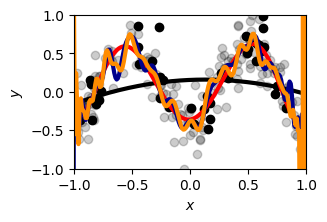

In [9]:
degree = [2,6,50,100]
color = ['black','red','darkblue','darkorange']
fig = plt.figure(figsize=(3., 2.))
plt.plot(norm_X_train,norm_y_train,'ko',alpha=0.2)
plt.plot(norm_X_test,norm_y_test,'ko')
for i in range(len(degree)):
    poly_features = PolynomialFeatures(degree=degree[i], include_bias=False)
    norm_X_poly = poly_features.fit_transform(norm_X_train)
    lin_reg = LinearRegression() # linear regression model
    lin_reg.fit(norm_X_poly,norm_y_train) # fit model
    norm_x_poly = poly_features.fit_transform(norm_x)
    norm_y_predicted = lin_reg.predict(norm_x_poly)
    y_predicted = scaling(norm_y_predicted,inverse_transform=True,param=param_y)
    plt.plot(norm_x,norm_y_predicted,'-',color=color[i],linewidth=3,label=str(degree[i]))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-1,1)
plt.xlim(-1,1)
plt.show()

The results are depicted in Figure above and from them we can draw some conclusions: (i) a quadratic model is unable to fit our data and (ii) high-degree -- 50 and 100, here -- polynomial models wiggle around to get as close as possible to the training data points. This means the quadratic model is underfitting. Conversely, the higher the polynomial degree is, the more our model tends to overfit.

So, how can we select the best models -- that is, the one that will generalize best? To answer we move to the second point of this example: model validation.

### Validation

A crucial aspect in finding model that generalizes the best is to perform hold-out validation. To this end, we should assess the model's performance by examining the validation error at varying of the size of the training set (and any eventual hyperparameter). By repeatedly training the model on subsets of varying sizes from the training set, we can generate informative plots that will guide us in selecting the model with the minimum error on the validation set.

Below we implement a function that is designed to plot the training, validation, and test errors of models with different polynomial degrees (up to 40).

In [10]:
def learning_curves(X_train, y_train, X_test, y_test, degree):
    degree +=1
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
    norm_X_val = scaling(X_val,transform=True,param=param_x) 
    model = LinearRegression()
    train_errors = np.zeros((degree-1,len(X_train)-1))
    val_errors = train_errors.copy()
    test_errors = train_errors.copy()
    for deg in range(1,degree):
        for m in range(1, len(X_train)):
            # Construct polynomial library up to degree
            poly_features = PolynomialFeatures(degree=deg, include_bias=False)
            X_train_poly = poly_features.fit_transform(norm_X_train) 
            X_val_poly = poly_features.fit_transform(norm_X_val)
            X_test_poly = poly_features.fit_transform(norm_X_test) 
            # Fit model
            model.fit(X_train_poly[:m], y_train[:m])
            # Predict training, validation, and test 
            y_train_predict = model.predict(X_train_poly[:m])
            y_val_predict = model.predict(X_val_poly)
            y_test_predict = model.predict(X_test_poly)
            # Store errors
            train_errors[deg-1,m-1] = mean_squared_error(y_train[:m], y_train_predict)
            val_errors[deg-1,m-1] =mean_squared_error(y_val, y_val_predict)
            test_errors[deg-1,m-1] = mean_squared_error(y_test, y_test_predict)
    return train_errors, val_errors, test_errors

train,val,test = learning_curves(norm_X_train, norm_y_train, norm_X_test, norm_y_test, degree=40)

Let first have a look at the error on the training and validation sets for a sixth-degree polynomial model, depicted below.

We start by analyzing the behavior of the training error. When there is a small bunch of training points, the model can perfectly fit those data and results in zero error. However, as more points are added, the model struggles to fit the data precisely due to the noise that we artificially added and the intrinsic non-linearity of the function we are trying to fit. Thus, the error on the training data increases until it reaches a plateau where additional data won't significantly affect the mean error.

An analysis on the validation error however rapidly reveals that things are quite different. When there is a small bunch of training points, the model clearly fails to generalize well and leads to relatively high validation errors. As the model is exposed to more training points, it gradually learns and improves, causing the validation error to decrease and, in this example, to reach approximately the same plateau of the training error. 

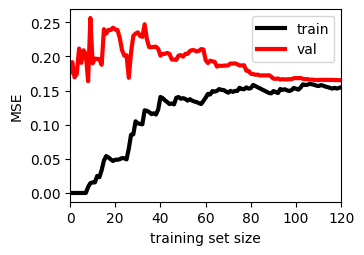

In [11]:
fig = plt.figure(figsize=(3.5, 2.5))
plt.plot(train[6,:],color='black',linewidth=3,label='train')
plt.plot(val[6,:],color='red',linewidth=3,label='val')
plt.ylabel('MSE',fontsize="10")
plt.xlabel('training set size',fontsize="10")
plt.xlim(0,120)
plt.legend(loc='best')
plt.show()

We are now ready to look at the big picture, just below, where we can see the variation of the training, validation, and (optionally) test error at varying of both the polynomial degree and the size of the training set.


The training error presents the same aforementioned behavior. Additionally, we can observe that for any polynomial degree smaller than 6, the error is high -- that is, the model is underfitting the training data. Instead, as we increase the degree of the model, we observe a slight reduction of the error (caused by overfitting the training data).

If we move to the validation error, we observe that for training sets smaller than a certain size, the model does not generalize well (exactly as before). However, in addition, we (re-)discover overfitting. For degrees larger than 20, the model overfits the training data and cannot accurately predict any other data different from the training set (high validation error).

This shows the benefit of hold-out validation: the validation set allows us to pick up the best model(s) as the one(s) that presents the minimum validation error -- approximately corresponding to a degree equal to 16, in this example. Once we have selected such model, we can deploy it to make prediction of new/unseen data -- that is, the test set. And, indeed, the minimum error region for the test set is located within the region where the validation error is minimum.

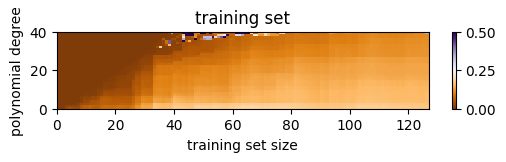

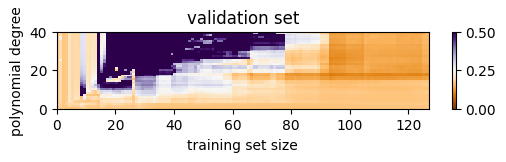

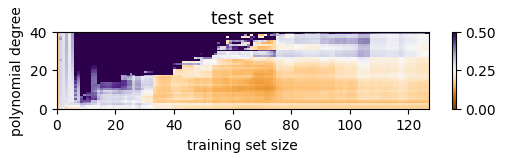

In [12]:
fig = plt.figure(figsize=(6., 1.))
cax=plt.pcolor(train, cmap='PuOr',vmin=0.0, vmax=0.5)
cbar = fig.colorbar(cax)
plt.ylabel('polynomial degree')
plt.xlabel('training set size')
plt.title('training set')
plt.show()


fig = plt.figure(figsize=(6., 1.))
cax=plt.pcolor(val, cmap='PuOr',vmin=0.0, vmax=0.5)
cbar = fig.colorbar(cax)
plt.ylabel('polynomial degree')
plt.xlabel('training set size')
plt.title('validation set')
plt.show()

fig = plt.figure(figsize=(6., 1.))
cax=plt.pcolor(test, cmap='PuOr',vmin=0.0, vmax=0.5)
cbar = fig.colorbar(cax)
plt.ylabel('polynomial degree')
plt.xlabel('training set size')
plt.title('test set')
plt.show()

An alternative to the above laborious evaluation of the model's performances at varying of the training set size consists of using Scikit-Learn’s k-fold cross-validation$^*$.

The code below, considering a polynomial regression of degree six, splits randomly the training set into five distinct folds, then it trains and evaluates the model five times, picking a different fold for evaluation every time and training on the other four folds. The result is an array containing the five evaluation scores:


$^*$ *Note that cross_val_score expects an objective function to be maximized, so the scoring function is actually the opposite of the MSE.*

In [13]:
from sklearn.model_selection import cross_val_score
poly_features = PolynomialFeatures(degree=6, include_bias=False)
X_train_poly = poly_features.fit_transform(norm_X_train) 
scores = cross_val_score(lin_reg, X_train_poly, norm_y_train,
                         scoring="neg_mean_squared_error",
                         cv=5)
mse_scores = -scores
print('Scores: ', mse_scores)
print('Mean scores: ', np.mean(mse_scores))
print('Standard deviation scores: ', np.std(mse_scores))

Scores:  [0.09159855 0.07245614 0.04068157 0.04406373 0.03980408]
Mean scores:  0.057720814999062856
Standard deviation scores:  0.020797558312019494


# Section 6. Regularization techniques


(Non)linear regression deals, most of the time, with overdetermined systems of equations -- all examples we have looked up so far are indeed characterized by $n\gg m$. We should not be surprised, at this moment, that the same penalty terms that are used for the solution of overdetermined systems have their own counterparts (and names) in regression. Regularized regression models based on the $\ell_1$ and $\ell_2$ norms are called LASSO -- Least Absolute Shrinkage and Selection Operator Regression --, and Ridge, respectively. The combination of both is often referred to as Elastic net.

## LASSO

LASSO regression is the (non)linear regression version with a regularization term proportional to $||\boldsymbol{\theta}||_1$. This forces the learning algorithm to not only fit the data but also shrink the model parameters to zero. The loss function is thus defined as

\begin{equation}
\mathcal{L}^{\text{LASSO}}\left(\mathbf{X},f_{\boldsymbol{\theta}} \right) = \text{MSE}\left(\mathbf{X},f_{\boldsymbol{\theta}} \right)+\lambda_1 ||\boldsymbol{\theta}||_1.
\end{equation}

The above loss function is not differentiable at $\boldsymbol{\theta}=\mathbf{0}$, this means we cannot derive a closed-form solution of the type (1). However, we can still use gradient descent provided that we define the following modified gradient, whenever $\boldsymbol{\theta}$ is equal to zero,

\begin{equation}
    \text{grad} \left(\boldsymbol{\theta},\mathcal{L}^{\text{LASSO}}\right) = \dfrac{\partial}{\partial \boldsymbol{\theta}}\text{MSE}(\mathbf{X},f_{\boldsymbol{\theta}})+\text{sign}\left(\boldsymbol{\theta}\right),
\end{equation}

where $\text{sign}(\cdot)$ is the sign function.



In [14]:
from sklearn.linear_model import Lasso
lambda_1 = 0.0001
lasso_reg = Lasso(alpha=lambda_1,max_iter=100000) # define lambda_1
# Polynomial feature up to degree 100
poly_features = PolynomialFeatures(degree=100, include_bias=False)
lasso_reg.fit(norm_X_poly,norm_y_train) # fit LASSO reg model
norm_x_poly = poly_features.fit_transform(norm_x)
norm_y_predicted_lasso = lasso_reg.predict(norm_x_poly) # make predictions

For the sake of completeness, note that we could also use Scikit-learn's SGDRegressor with the following arguments: penalty="l1" and alpha=lambda_1:

In [15]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=10000,
                       tol=1e-6,penalty="l1",alpha=lambda_1,
                       eta0=0.01)
sgd_reg.fit(norm_X_poly,norm_y_train.ravel())
norm_y_predicted_sgd = sgd_reg.predict(norm_x_poly) # make predictions

## Ridge

Ridge regression is the (non)linear regression version with a regularization term proportional to $||\boldsymbol{\theta}||^2_2$ that forces the model parameters to be as small as possible. The loss function is defined as

\begin{equation}
\mathcal{L}^{\text{Ridge}}\left(\mathbf{X},f_{\boldsymbol{\theta}} \right) = \text{MSE}\left(\mathbf{X},f_{\boldsymbol{\theta}} \right)+\lambda_2 ||\boldsymbol{\theta}||^2_2.
\end{equation}

As with linear regression -- and differently from LASSO --, we can perform Ridge regression either by computing a closed-form equation or by performing gradient descent. The code hereinafter implements the closed-form solution using Scikit-learn's Ridge:

In [16]:
from sklearn.linear_model import Ridge
lambda_2 = lambda_1
ridge_reg = Ridge(alpha=lambda_2,max_iter=100000) # define lambda_2
ridge_reg.fit(norm_X_poly,norm_y_train) # fit Ridge reg model
norm_y_predicted_ridge = ridge_reg.predict(norm_x_poly) # make predictions

## Elastic Net

Elastic net is the middle version between LASSO and Ridge. Accordingly, the regression model is regularized with respect to both the $\ell_1$ and $\ell_2$ norms.  The regularization term is a mix of both Ridge and LASSO's controlled by a ratio $\varrho$:

\begin{equation}
\mathcal{L}^{\text{Elastic net}}\left(\mathbf{X},f_{\boldsymbol{\theta}} \right) = \text{MSE}\left(\mathbf{X},f_{\boldsymbol{\theta}} \right)+\varrho\lambda||\boldsymbol{\theta}||_1+\dfrac{1-\varrho}{\varrho}\lambda||\boldsymbol{\theta}||^2_2.
\end{equation}

Elastic net is equivalent to Ridge if $\varrho=0$ and to LASSO if $\varrho=1$. 

In [17]:
from sklearn.linear_model import ElasticNet
net_reg = ElasticNet(alpha=2*lambda_2,l1_ratio=1.0,max_iter=100000)
net_reg.fit(norm_X_poly,norm_y_train) # fit Elastic Net reg model
norm_y_predicted_net = net_reg.predict(norm_x_poly) # make predictions

We can now proceed to the comparison of the above three regularized regression models.

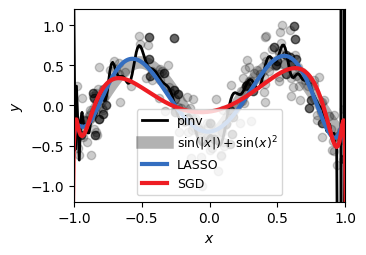

In [18]:
# re-generate data set without measurement noise
X = np.linspace(-np.pi,np.pi,(n_snapshots))
y = np.sin(np.abs(X))+np.sin(X)**2
y = scaling(y,transform=True,param=param_y)
X = scaling(X,transform=True,param=param_x)

# plot predictions, training and test data, and true model
fig = plt.figure(figsize=(3.5, 2.5))
plt.plot(norm_X_train,norm_y_train,'o',color='black',alpha=0.2,markersize=6,)
plt.plot(norm_X_test,norm_y_test,'o',color='black',alpha=0.6,markersize=6)
plt.plot(norm_x,norm_y_predicted,color='black',alpha=1,linewidth=2,label='pinv')
plt.plot(X,y,color='black',linewidth=9,alpha=0.3,label='$\sin(|x|)+\sin(x)^2$')
plt.plot(norm_x,norm_y_predicted_lasso,color=colorb,linewidth=3,label='LASSO')
plt.plot(norm_x,norm_y_predicted_sgd,color=colorr,alpha=1,linewidth=3,label='SGD')
plt.ylabel('$y$')
plt.xlabel('$x$')
plt.ylim(-1.2,1.2)
plt.xlim(-1,1)
plt.legend(loc='best',fontsize="9")